# LMI characterization of $L\infty$ gain

The $L_\infty$ gain characterizes the ratio of the maximum values of the output to the input. This is useful for computing th reachable set for the output. The reachable set can then be used in formal analysis to verify system safety.

source: [AAE 666 Class Notes](papers/aae666-notes.pdf) (Martin Corless) pg. 178/ pg. 265

Consider a disturbed linear system:

\begin{align*}
\dot{x} = Ax + Bw\\
z = Cx + Dw
\end{align*}

where all eigenvalues of A have negative real part and w is a bounded input.
Suppose there exists a positive real scalar $\alpha$ such that:

\begin{align*}
\begin{pmatrix}
PA + A^TP + 2\alpha P & PB\\
B^TP & -2\alpha \mu_1 I
\end{pmatrix} < 0\\
\begin{pmatrix}
C^TC - P & C^T D \\
D^TC & D^TD - \mu_2 I
\end{pmatrix} < 0
\end{align*}

Then
$||y(t)||_{\infty} \leq \beta e^{-\alpha t} + \gamma ||u(t)||_{\infty} \leq \beta  + \gamma ||u(t)||_{\infty}$
where

\begin{align*}
\beta &= x_0^TPx_0\\
\gamma &= \sqrt{\mu_1 + \mu_2}
\end{align*}

Since $\alpha$ and P cannot both be a variable in the LMI in order for it to be linear, a line search must be performed to minimize $\gamma$ by changing $\alpha$. It is beneficial to minimize $\gamma$ since it is the bound at steady state while $\alpha$ represents the transient behaviour.

In [60]:
%pylab inline
import picos as pic
import cvxopt as cvx
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
def solve_bounded_disturbance(A, B, C, D):
    
    def solve_lmi(A_data, B_data, C_data, D_data, alpha, verbose=False):
        sdp = pic.Problem()

        # shape
        n_x = A_data.shape[0]
        n_u = B_data.shape[1]
        
        # variables
        P = sdp.add_variable('P', (n_x, n_x), vtype='symmetric')
        alpha = pic.new_param('alpha', alpha)
        mu_1 = sdp.add_variable('mu_1')
        mu_2 = sdp.add_variable('mu_2')

        # parameters
        A = pic.new_param('A', cvx.matrix(A_data))
        B = pic.new_param('B', cvx.matrix(B_data))
        C = pic.new_param('C', cvx.matrix(C_data))
        D = pic.new_param('D', cvx.matrix(D_data))
        I_n_u = pic.new_param('I', cvx.sparse(cvx.matrix(np.eye(n_u))))
        I_n_x = pic.new_param('I', cvx.sparse(cvx.matrix(np.eye(n_x))))

        eps = 1e-10
        sdp.add_constraint(
            (P*A + A.T*P + 2*alpha*P & P*B) //
            (B.T*P &  -2*alpha*mu_1*I_n_u)  << -eps)
        sdp.add_constraint(
            (C.T*C - P & C.T*D) //
            (D.T*C & D.T*D - mu_2*I_n_u)  << -eps)
        sdp.add_constraint(P >> eps*I_n_x)
        sdp.add_constraint(mu_1 >> eps)
        sdp.add_constraint(mu_2 >> eps)
        sdp.set_objective('min', mu_1 + mu_2)
        try:
            sdp.solve(verbose=verbose)
            mu_1 =  sdp.variables['mu_1'].value
            mu_2 =  sdp.variables['mu_2'].value
            gamma = np.sqrt(mu_1 + mu_2)
        except Exception as e:
            print(e)
            gamma = -1
            
        return gamma, sdp
    
    # we use fmin to solve a line search problem in alpha for minimum gamma
    print('line search')
    alpha_opt  = scipy.optimize.fmin(lambda alpha: solve_lmi(A, B, C, D, alpha)[0], x0=0.01)
    
    gamma, sdp = solve_lmi(A, B, C, D, alpha_opt)
    print(sdp)
    
    if sdp.status == 'optimal':
        P = sdp.variables['P'].value
        mu_1 =  sdp.variables['mu_1']
        mu_2 =  sdp.variables['mu_2']
        print('optimal alpha: ', alpha_opt)
        print('gamma: ', gamma)
        print('mu_1: ', mu_1)
        print('mu_2: ', mu_2)
        print('P: ',  P)
    else:
        sdp = solve_lmi(A, B, C, D, alpha_opt, verbose=True)
        raise RuntimeError('Optimization failed')
        
    return sdp, P, alpha_opt, gamma

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [61]:
import control

A = array([[0,1],[-1,-1]])
B = array([[0],[1]])
C = eye(2)
D = array([[0], [0]])

sdp, P, alpha, gamma = solve_bounded_disturbance(A, B, C, D)

sys = control.ss(A, B, C, D)

mag, phase, omega = control.freqresp(sys, logspace(-2,2,100))
i_h_inf_norm = mag.argmax()
omega_h_inf_norm = omega[i_h_inf_norm]
h_inf_norm = mag[0,0,i_h_inf_norm]

line search
Optimization terminated successfully.
         Current function value: 1.687567
         Iterations: 19
         Function evaluations: 38
Semidefinite Program
  minimize mu_1 + mu_2
  over
    1×1 real variable mu_i+1 ∀ i ∈ [0…1]
    2×2 symmetric variable P
  subject to
    [P·A + Aᵀ·P + 2·alpha·P, P·B; Bᵀ·P, -2·alpha·mu_1·I] ≼ -1e-10·I
    [Cᵀ·C - P, Cᵀ·D; Dᵀ·C, Dᵀ·D - mu_2·I] ≼ -1e-10·I
    P ≽ 1e-10·I
    mu_1 ≽ 1e-10
    mu_2 ≽ 1e-10
optimal alpha:  [0.20525]
gamma:  1.6875672895616116
mu_1:  2.8478833565689623
mu_2:  2.2936175312823912e-10
P:  [ 1.21e+00  2.83e-01]
[ 2.83e-01  1.38e+00]




         Current function value: 1.687567
         Iterations: 19
         Function evaluations: 38
---------------------
optimization problem  (SDP):
5 variables, 0 affine constraints, 17 vars in 5 SD cones

P 	: (2, 2), symmetric
mu_2 	: (1, 1), continuous
mu_1 	: (1, 1), continuous

	minimize mu_1 + mu_2
such that
  [P*A + A.T*P + 2.0*alpha*P,P*B;B.T*P,( ( ( -2.0 )*alpha )*mu_1 )*I] ≼ |-1e-10|
  [C.T*C -P,C.T*D;D.T*C,D.T*D -mu_2*I] ≼ |-1e-10|
  P ≽ ( 1e-10 )*I
  mu_1 ≽ 1e-10
  mu_2 ≽ 1e-10
---------------------
optimal alpha:  [ 0.20525]
gamma:  1.68756728435
mu_1:  2.84788333291
mu_2:  6.30723574201e-09
P:  [ 1.21e+00  2.83e-01]
[ 2.83e-01  1.38e+00]



In [52]:
def sim_discrete(x0, t_vect, f_dynamics, f_measure, f_control, f_disturbance, n_x, n_y, n_u, n_d):
    sim = scipy.integrate.ode(f_dynamics)
    sim.set_initial_value(x0)
    n_t = len(t_vect)
    
    # initialize
    x = x0
    y = f_measure(0, x, zeros(n_u), zeros(n_d))
    u = f_control(y)
    d = f_disturbance(t_vect[0], x, y, u)
    
    x_vect = zeros((n_t, n_x))
    y_vect = zeros((n_t, n_y))
    u_vect = zeros((n_t, n_u))
    d_vect = zeros((n_t, n_d))
    
    # loop
    for i in range(n_t):
        t = t_vect[i]
        # integrate past step
        if (i > 0):
            sim.set_f_params(u, d)
            sim.integrate(t)
        x = sim.y
        y = f_measure(t, x, u, d)
        u = f_control(y)
        d = f_disturbance(t, x, y, u)
        # record data
        x_vect[i,:] = x
        y_vect[i,:] = y
        u_vect[i,:] = u
        d_vect[i,:] = d
        # update control and integrate
        
        sim.set_f_params(u, d)

    return x_vect, y_vect, u_vect, d_vect

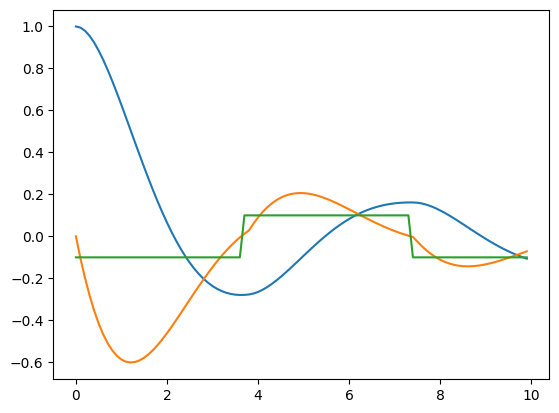

In [53]:
x0 = [1,0]
t = arange(0, 10, 0.1)
x, y, u, d = sim_discrete(
    x0, t,
    f_dynamics=lambda t, x, u, d: A.dot(x) + B.dot(u + d),
    f_measure=lambda t, x, u, d: C.dot(x) + D.dot(u + d),
    f_control=lambda y: array([0]),
    f_disturbance=lambda t, x, y, u: 0.1 if y[1] > 0 else -0.1,
    n_x=2, n_y=2, n_u=1, n_d=1)
plot(t, y);
#plot(t, u);
plot(t, d);

In [54]:
def sim_disturbances(sys, t, x0_list, u_array):
    
    # simulate all trajectories
    n_d = u_array.shape[1]
    n_x = sys.nstates
    n_y = sys.noutputs
    n_u = sys.ninputs
    n_t = len(t)
    
    x = np.zeros((n_d*n_x, n_x, n_t))
    y = np.zeros((n_d*n_x, n_y, n_t))
    u = np.zeros((n_d*n_x, n_u, n_t))
    
    n = 0
    for i in range(n_d):
        for j in range(n_x):
            u_i = u_array[:,i]
            x0 = x0_list[j]
            t, y_i, x_i = control.forced_response(
                sys, T=t, U=u_i, X0=x0, return_x = True)
            #plot(t,y.T)
            y[n, :, :] = y_i
            x[n, :, :] = x_i
            u[n, :] = u_i
            n += 1
    return y, x

In [92]:
def plot_disturbance(t, y, x0_list, u_inf):
    for yi in y:
        norm_y = sqrt(yi.T*yi.T)
        plot(t, norm_y)

    beta = max([sqrt(x0.T.dot(P).dot(x0)) for x0 in x0_list])

    # plot bounds
    alpha_lin = 0.5

    h_inf = plot(t, u_inf*(beta*exp(-alpha_lin*t) + h_inf_norm), 'r--')
    h_lmi = plot(t, u_inf*(sqrt(beta**2*exp(-2*alpha*t) + gamma**2)), 'g-')
    legend([h_inf[0], h_lmi[0]], ['$H_\infty$ bound', 'LMI bound'], loc='upper right') 

In [93]:
# try to find worst frequency
mag, phase, omega = control.freqresp(sys, logspace(-2,2,1000))
i_h_inf_norm = mag.argmax()
omega_h_inf_norm = omega[i_h_inf_norm]
h_inf_norm = mag[0,0][i_h_inf_norm]
h_inf_norm, omega_h_inf_norm

(np.float64(1.1546999941747125), np.float64(0.707701066118189))

u_inf 1


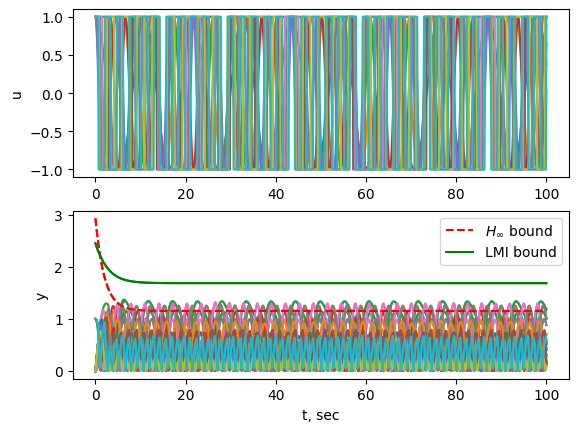

In [104]:
t = linspace(0,100,1000)
x0_list = array([[p0, v0] for p0 in linspace(0,1,2) for v0 in linspace(0,1,2)])
f_list = linspace(0.5*h_inf_norm, 2*h_inf_norm, 5)
phi_list = linspace(0, 2*pi, 1)
for u_inf in [1]:
    print('u_inf', u_inf)
    u_sin = u_inf*array([ cos(f*t - phi) for f in f_list for phi in phi_list]).T
    u_square = u_inf*array([ where(  cos(f*t - phi) > 0, 1, -1) for f in f_list for phi in phi_list]).T
    
    y_sin, x_sin = sim_disturbances(sys, t, x0_list, u_sin)
    y_square, x_square = sim_disturbances(sys, t, x0_list, u_square)

    plt.figure()
    
    subplot(211)
    plot(t, u_sin)
    ylabel('u')
    #title('sinudoid input')
    grid()
    subplot(212)
    plot_disturbance(t, y_sin, x0_list, u_inf)
    grid()
    xlabel('t, sec')
    ylabel('y')
    #title('output Euclidean norm')
    savefig('figures/hinf_lyap_compare_sine.pdf')
    
    subplot(211)
    plot(t, u_square)
    ylabel('u')
    #title('square input')
    grid()
    subplot(212)
    plot_disturbance(t, y_square, x0_list, u_inf)
    grid()
    xlabel('t, sec')
    ylabel('y')
    
    #text(6,3, '$H_\infty$ bound exceeded')
    #title('output Euclidean norm')
    savefig('figures/hinf_lyap_compare_square.pdf')

Note that LMI bound is tighter than LMI bound 2 which relies on the triangle inequality.

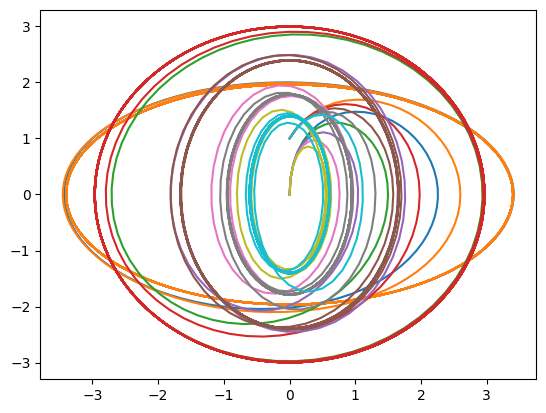

In [102]:
plot(x_sin.T[:,0,:], x_sin.T[:,1,:]);

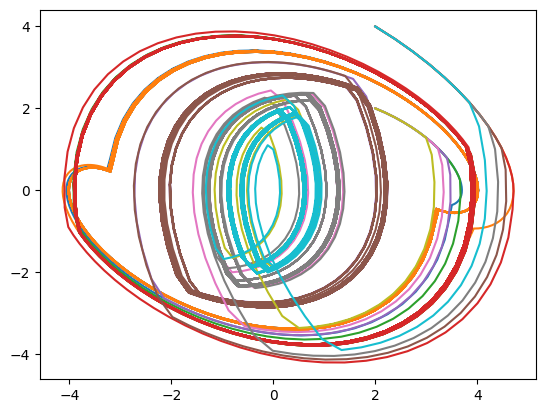

In [97]:
plot(x_square.T[:,0,:], x_square.T[:,1,:]);

In [98]:
beta = max([sqrt(x0.T.dot(P).dot(x0)) for x0 in x0_list])
beta

np.float64(7.105675712494051)